In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import threadpoolctl
import lightgbm as lgb

import warnings
import pprint
warnings.filterwarnings('ignore')

# TLDR: 
Using Starcraft player data, we are able to create a model that classifies a player's ladder ranking by leveraging a combination of features such as `APM`, `Unique Hotkeys`, `MinimapRightClicks` etc. We tested three different models using cross validation and found that LightGBM performs the best with an accuracy of 0.366 and an f1-score of 0.365, which performs has better accuracy than simply predicting the majority class. 

That being said, this accuracy is not good enough for deployment, and we would recommend iterating on this by collecting more data. This means we should collect more samples, especially for ranks that are under-represented in the current dataset, and also collect more features, such as the player's in-game main race and macro-focused features. 

In [2]:
data = pd.read_csv("starcraft_player_data.csv", na_values = "?")
data.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3340.000000,3339.000000,3338.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.647904,15.910752,960.421809,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.206341,11.962912,17318.133922,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


# Exploratory Data Analysis

With any ELO-based ranking system, we can expect that there is reasonable skew in the higher ranks, which the plot shows below. This imbalance requires some additional adjustments to the models, including down/up-sampling and prioritizing F1-score when evaluating on the validation sets.

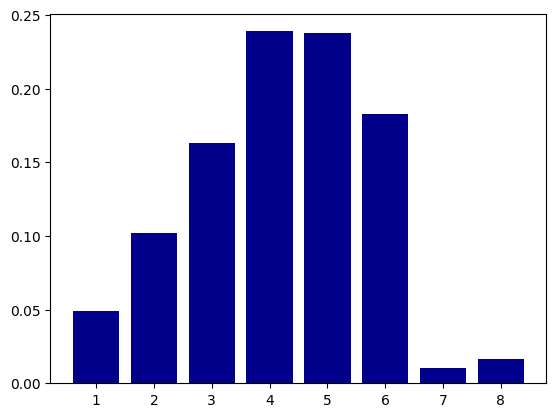

In [3]:
# check labels for any imbalances
rank_distribution = data.LeagueIndex.value_counts(normalize = True).sort_index()
plt.bar(rank_distribution.index, rank_distribution.values, color = '#00008B')
plt.show()

Moreover, it seems that most of the data is present, except for the age, hours/week and total hours features for professional ranked players. 

There is a couple options here. First, if care about all eight ranks, including professionals, then we will have to remove age, hours/week and total hours from the classifier. It is impossible to impute these values correctly due to the features not being missing at random. 

Second, if we only care about ranks 1-7 (ex. if we're selling a product that would primarily be used by lower ranked), then it would make sense to remove the professional players from the data set. Even if professional players exist in the real-life test setting, they would likely be classified as 7 and still wouldn't be the target of the product.

We can try to model both versions of the data.

In [4]:
data[data['LeagueIndex'] == 8].head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.0
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.0
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.0
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.0
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.0


In [5]:
# also a couple errant NaNs from observations whose LeagueIndex = 5
data[(data['LeagueIndex'] != 8) & (data['TotalHours'].isna())]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17.0,20.0,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18.0,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338


Continuing with this investigation into total hours, there are clearly some values that are impossible ex. one observation has total hours being 1,000,000. 

Note that HoursPerWeek and TotalHours are the only self-reported features, so presumably the other features should not be impacted by the measurement error. This means that, provided we do not use either of the features, we can retain the observations. 

For the version of the dataset that does use totalhours, we can remove some of the observations by using TotalHours and HoursPerWeek to deduce how many years the observation has played. Let's assume that we collect this starcraft data 5 years into the game's lifespan and exclude any observation who indicates they've played for more than 5 years. 

In [6]:
# also a some values that are clearly impossible that can be seen in the 
# initial describe above
data[data['TotalHours'] > 5000]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
7,72,7,17.0,42.0,10000.0,212.6022,0.009040,0.000676,6,0.001164,0.001253,0.004952,24.6117,41.7671,6.6104,45,0.002277,9,0.000129,0.000249
10,83,3,16.0,16.0,6000.0,153.8010,0.001677,0.000319,4,0.000000,0.000822,0.003772,23.4107,48.0711,7.0044,24,0.001593,7,0.000000,0.000017
770,2246,5,22.0,16.0,20000.0,248.0490,0.023703,0.000391,7,0.000000,0.000205,0.004651,37.8795,45.3760,4.7560,21,0.001526,6,0.000000,0.000000
1793,5140,5,18.0,24.0,1000000.0,281.4246,0.023428,0.000799,5,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29,0.001328,6,0.000000,0.000000
1978,5610,4,22.0,10.0,18000.0,152.2374,0.011983,0.000206,1,0.000016,0.000364,0.003351,52.1896,63.9811,4.9575,19,0.000680,5,0.000000,0.000000
2140,6020,5,22.0,10.0,9000.0,106.0056,0.003569,0.000635,8,0.000946,0.000575,0.003617,28.6645,55.9603,4.6159,25,0.001018,8,0.000000,0.000156
2216,6242,3,24.0,20.0,10260.0,76.5852,0.000780,0.000197,0,0.000063,0.000316,0.002438,42.9480,84.6340,5.9107,27,0.000450,10,0.000246,0.000358
2324,6518,6,20.0,8.0,25000.0,247.0164,0.015794,0.000438,8,0.000308,0.001339,0.004645,17.6471,37.1837,6.5944,29,0.001860,6,0.000000,0.000012
3253,9055,3,19.0,20.0,6000.0,102.0114,0.002045,0.000317,5,0.000044,0.000555,0.003032,62.5423,67.3140,6.3605,24,0.001410,6,0.000238,0.001948


In [7]:
# also people who probably misreporting HoursPerWeek 
data[data['HoursPerWeek'] > 84]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
237,711,5,17.0,96.0,900.0,145.8060,0.010374,0.000596,4,0.000000,0.000030,0.003965,43.2906,54.4060,4.3008,21,0.001014,8,0.000000,0.000104
690,2000,6,16.0,168.0,1260.0,233.3058,0.017521,0.000744,10,0.000178,0.000235,0.005137,25.5962,38.9165,5.0961,43,0.001027,10,0.000315,0.000502
1280,3733,6,24.0,112.0,1500.0,139.7598,0.005748,0.000368,4,0.000213,0.000155,0.005011,24.6822,41.8956,4.1489,28,0.000756,5,0.000000,0.000000
1299,3768,5,22.0,90.0,1000.0,89.6652,0.001847,0.000360,5,0.000172,0.000297,0.002551,37.2099,71.6074,5.8834,13,0.000986,5,0.000094,0.000031
1654,4754,7,18.0,98.0,700.0,236.0316,0.015664,0.001015,10,0.000366,0.001632,0.006487,18.7787,29.9871,4.3371,25,0.001507,8,0.000000,0.000000
1677,4817,6,21.0,140.0,1800.0,197.7774,0.006001,0.000383,4,0.000308,0.001307,0.004445,29.9962,42.8764,7.0019,32,0.001365,11,0.000058,0.000350
2662,7435,4,34.0,96.0,400.0,56.8584,0.000059,0.000029,1,0.000029,0.000265,0.001530,47.6078,129.8462,6.9038,11,0.000765,5,0.000000,0.000000


The following cell shows the NA removals (either removing rows with NAs or removing columns with NAs) and faulty self-reported `TotalHours` and `HoursPerWeek`

In [24]:
# remove age, hoursperweek, totalhours 
# so that we can still classify professional players
data_cols_removed = data.dropna(axis = 1)

# remove some observations that have faulty totalhours and hoursperweek
data_rows_removed = data[~((data['HoursPerWeek'] > 84) | 
              ((data['TotalHours']/data["HoursPerWeek"]/52)>5))].dropna(axis = 0)


In [25]:
data_rows_removed.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000
mean,4716.131738,4.111145,21.656269,15.778922,627.220472,114.243658,0.003996,0.000364,4.310721,0.000093,0.000379,0.003429,40.781669,64.316671,5.263329,22.104785,0.001031,6.536644,0.000060,0.000141
std,2657.468362,1.449149,4.211065,11.026154,522.295281,47.943361,0.004702,0.000210,2.334702,0.000159,0.000358,0.000965,17.097742,19.027080,1.503526,7.446299,0.000522,1.857468,0.000111,0.000264
min,56.000000,1.000000,16.000000,2.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2418.000000,3.000000,19.000000,8.000000,300.000000,78.992550,0.001240,0.000201,3.000000,0.000000,0.000138,0.002739,29.345525,51.092925,4.253750,17.000000,0.000681,5.000000,0.000000,0.000000
50%,4781.000000,4.000000,21.000000,12.000000,500.000000,106.865100,0.002426,0.000348,4.000000,0.000039,0.000278,0.003369,37.139950,61.358600,5.082850,22.000000,0.000903,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,139.826250,0.004897,0.000493,6.000000,0.000112,0.000508,0.004000,48.568950,74.196825,6.026675,27.000000,0.001258,8.000000,0.000087,0.000180
max,9271.000000,7.000000,44.000000,84.000000,10000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


## Checking signals

Now we can do a bit more exploration into the trends. It'll be good to see if we can pick up any signals prior to modeling. 

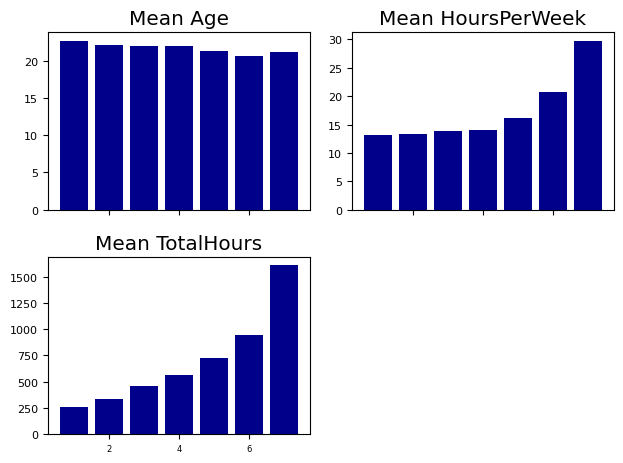

In [314]:
# check features unique to the data without pros
fig, axs = plt.subplots(2,2, sharex = True)
plt.rc('font', size = 12)
for i, feat in enumerate(['Age', "HoursPerWeek", "TotalHours"]):
    means = data_rows_removed.groupby("LeagueIndex")[feat].mean().sort_index()
    axs[int(i/2), int(i%2)].bar(means.index, means.values, color = '#00008B')
    axs[int(i/2), int(i%2)].set_title("Mean {}".format(feat))

fig.delaxes(axs[1,1])
fig.tight_layout()
plt.show()

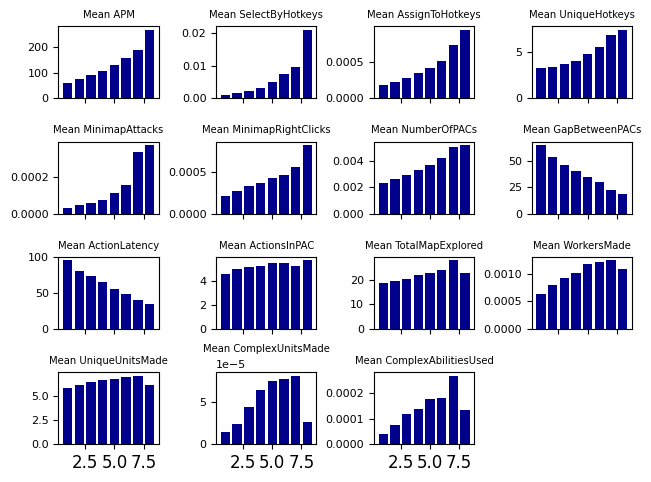

In [315]:
other_feats = ['APM', 'SelectByHotkeys', 'AssignToHotkeys',
       'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
       'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
       'ComplexAbilitiesUsed']
fig, axs = plt.subplots(4,4, sharex = True)
plt.rc('font', size = 6)
plt.rc('ytick', labelsize =8)
for i, feat in enumerate(other_feats):
    means = data_cols_removed.groupby("LeagueIndex")[feat].mean().sort_index()
    axs[int(i/4), int(i%4)].bar(means.index, means.values, color = '#00008B')
    axs[int(i/4), int(i%4)].set_title("Mean {}".format(feat))
fig.delaxes(axs[3,3])
fig.tight_layout()
plt.show()

Clearly, there's a lot of features that are correlated on average with the rankings. Notable ones are the APM and the hotkey related features, which make sense since Starcraft is a mechanically intensive game and the more a player is able to multi-task, the better they are in the ranks. Minimap usage correlation is also positively correlated, which could be some realization of map awareness. 

Other variables without clear trends such as `UniqueUnitsMade` can still be used in the modeling, and if there's really no trend then the data-driven, empirical model can hopefully resolve that.

# Models

We start by splitting the dataset into train/test sets. We will be using stratified k-fold cross-validation to select the best hyperparameters for the models.

In [10]:
def make_train_test_set(df, test_size, random_state = 100):
    X, y = df.iloc[:, 2:].to_numpy(), df.iloc[:, 1].to_numpy() 
    # stratify to keep distribution consistent
    return train_test_split(X, y, 
                            test_size = test_size, 
                            stratify = y,
                           random_state = random_state)

In [15]:
def create_pipeline(model, smote_val = None, undersample_val = None):
    SMOTE_NUM = smote_val
    UNDERSAMPLE_NUM = undersample_val
    def SMOTE_Distribution(y):
        labels = pd.Series(y).value_counts()
        SMOTE_dict = {}
        for i in labels.index:
            if labels[i] > SMOTE_NUM:
                SMOTE_dict[i] = labels[i]
            else:
                SMOTE_dict[i] = SMOTE_NUM
        return SMOTE_dict
    def UnderSample_Distribution(y):
        labels = pd.Series(y).value_counts()

        Undersample_dict = {}
        for i in labels.index:
            if labels[i] < UNDERSAMPLE_NUM:
                Undersample_dict[i] = labels[i]
            else:
                Undersample_dict[i] = UNDERSAMPLE_NUM
        return Undersample_dict
    
    seq = []
    
    if SMOTE_NUM:
        oversample = BorderlineSMOTE(sampling_strategy = SMOTE_Distribution)
        seq.append(('oversample', oversample))
    if UNDERSAMPLE_NUM:
        undersample = RandomUnderSampler(sampling_strategy = UnderSample_Distribution)
        seq.append(('undersample', undersample))
    seq.append(("scaler", StandardScaler()))
    seq.append(("model", model))
    
    pipeline = Pipeline(steps = seq)
    return pipeline

In [86]:
def display_results(y_true, y_pred):
    acc=sklearn.metrics.accuracy_score(y_true, y_pred)
    balanced_acc=sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
    f1=sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted')
    unagg_f1=sklearn.metrics.f1_score(y_true, y_pred, average = None)
    
    
    class_labels = np.sort(np.unique(y_true))
    unagg_f1_dict = {i:k for i, k in zip(class_labels, unagg_f1)}
    
    results_dict = {
        'acc': acc,
        'balanced acc': balanced_acc,
        'weighted f1': f1,
        'unaggregated f1': unagg_f1_dict
    }
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), 
                                  display_labels = [i for i in range(1,len(class_labels)+1)])
    disp.plot()
    return results_dict

## Linear SVC

To test pipeline concept, we will use a LinearSVC as a baseline. This model has some assumptions, specifically that the class boundaries can be modeled as linear. Otherwise, it's a fairly common model for multi-class classification. The only hyper-parameter we will really test is the penalty term.

In [102]:
# make the pipeline
X_train, X_test, y_train, y_test = make_train_test_set(data_cols_removed,
                                                      test_size = 0.2)



Cs = np.logspace(-3,3, num = 10)
for C in Cs:
    
    model = sklearn.svm.LinearSVC(dual = False, C = C)
    pipeline = create_pipeline(model, smote_val= 70, undersample_val = 500)
    cv = RepeatedStratifiedKFold(n_splits =5, n_repeats = 3, 
                             random_state = 100)
    scores = cross_val_score(pipeline, X_train, y_train, 
                         scoring = 'f1_weighted', cv = cv, n_jobs = -1)
    print("C: {}; mean f1: {}".format(C, np.mean(scores)))

C: 0.001; mean f1: 0.3286482651307633
C: 0.004641588833612777; mean f1: 0.33393867038261327
C: 0.021544346900318832; mean f1: 0.34237526081849823
C: 0.1; mean f1: 0.35036470632988337
C: 0.46415888336127775; mean f1: 0.35306595903440335
C: 2.154434690031882; mean f1: 0.35365813101379767
C: 10.0; mean f1: 0.3538045361205508
C: 46.41588833612773; mean f1: 0.3537896116342694
C: 215.44346900318823; mean f1: 0.35252353836000583
C: 1000.0; mean f1: 0.3530732275958729


The baseline so far is at C = 46.415, with an average weighted-f1 of 0.3536

## Shallow Neural Network

Neural networks have less assumptions built into them and can model non-linearities in the data better than the linear svc. The trade-off is NNs are generally data-hungry, especially as the layers grow. In expectation, the neural network may not perform as well (even relative to the linear SVC) due to the small sample size of the dataset.

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

class shallow_nn(nn.Module):
    """
    Inits a shallow NN for multi-class classification
    """

    def __init__(self, num_initial_feat, num_hidden, num_classes = 8, drop_prob = 0.2):
        super(shallow_nn, self).__init__()
        self.linear_1 = nn.Linear(num_initial_feat, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.linear_out = nn.Linear(num_hidden, num_classes)
        
        self.dropout_1 = nn.Dropout(drop_prob)
        self.dropout_2 = nn.Dropout(drop_prob)

    def forward(self, x):
        # forward through linear layers
        out = F.relu(self.linear_1(x))
        out = self.dropout_1(out)
        out = F.relu(self.linear_2(out))
        out = self.dropout_2(out)
        out = self.linear_out(out)
        return out
class player_dset(Dataset):
    def __init__(
        self,
        x,
        y
    ):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        x = self.x[index, :]
        y = self.y[index]
        
        return (x,y)
    def __len__(self):

        return len(self.x)
    
def acc_score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """

    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]

    preds = torch.argmax(logits, dim = -1)
    return preds

def evaluate(model, data_loader):
    model.eval()
    preds = []
    ys = []
    with torch.no_grad(), \
        tqdm(total=len(data_loader.dataset), disable = True) as progress_bar:
        for x,y in data_loader:
            out = model(x.float())
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            
            pred = acc_score(out, y)
            preds.extend(pred)
            ys.extend(y)
    f1 = sklearn.metrics.f1_score(ys, preds, average = 'weighted')
    model.train()
    return f1
            
batch_size = 64
hidden_size = 15
epochs = 8
lr = 0.01
l2_wd = 0.01

cv = RepeatedStratifiedKFold(n_splits =5, n_repeats = 2, 
                                 random_state = 100)
drop_probs = [0.1, 0.2, 0.4, 0.6]
hidden_sizes = [10, 20, 40, 80]
for drop_prob in drop_probs:
    for hidden_size in hidden_sizes:
        f1s = []
        for i, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
            scaler = StandardScaler()
            cv_x_train = scaler.fit_transform(X_train[train_index, :])
            cv_y_train = y_train[train_index]-1
            cv_x_val = scaler.transform(X_train[val_index, :])
            cv_y_val = y_train[val_index]-1

            # get datasets
            train_set = player_dset(cv_x_train, cv_y_train)
            val_set = player_dset(cv_x_val, cv_y_val)
            train_loader = DataLoader(train_set,
                                     batch_size = batch_size,
                                     shuffle = True)
            val_loader = DataLoader(val_set,
                                   batch_size = batch_size)

            # init model and optimizer
            model = shallow_nn(num_initial_feat = X_train.shape[1], 
                          num_hidden = hidden_size,
                          num_classes = len(np.unique(y_train)),
                              drop_prob = drop_prob)
            model = model.float()
            optimizer = optim.Adam(model.parameters(),
                                    lr = lr,
                                    betas = (0.9, 0.999),
                                    eps = 1e-7,
                                    weight_decay = l2_wd)

            # define the loss function
            weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', 
                                                                      classes= np.unique(cv_y_train), 
                                                                      y= np.array(cv_y_train))
            criterion = nn.CrossEntropyLoss(weight= torch.from_numpy(weights).type(torch.FloatTensor), reduction = 'mean')

            epoch = 0
            best_f1 = 0
            while epoch != epochs:
                epoch += 1
                with torch.enable_grad(), \
                    tqdm(total=len(train_loader.dataset), disable = True) as progress_bar:
                    for x, y in train_loader:
                        optimizer.zero_grad()
                        x = x.float()
                        y = y.type(torch.LongTensor)
                        out = model(x)


                        # calc loss and backprop
                        loss = criterion(out, y)
                        loss.backward()
                        optimizer.step()

                        # update progress bar
                        progress_bar.update(batch_size)
                        progress_bar.set_postfix(epoch = epoch,
                                                 loss = loss)
                f1 = evaluate(model, val_loader)
                if f1 > best_f1:
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, 'temp.pt')

            # load back in the best
            checkpoint = torch.load('temp.pt')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']

            # append best f1 to list of f1s for cv splits
            f1s.append(evaluate(model, val_loader))
        print("hidden", hidden_size, "drop_prob", drop_prob, np.mean(f1s))

hidden 10 drop_prob 0.1 0.33882883277676273
hidden 20 drop_prob 0.1 0.32349953080279237
hidden 40 drop_prob 0.1 0.30714565788394677
hidden 80 drop_prob 0.1 0.3073547616019097
hidden 10 drop_prob 0.2 0.32364599232614666
hidden 20 drop_prob 0.2 0.3028593479880995
hidden 40 drop_prob 0.2 0.31006904575874694
hidden 80 drop_prob 0.2 0.3108510188775661
hidden 10 drop_prob 0.4 0.30415342488009234
hidden 20 drop_prob 0.4 0.28670667392057353
hidden 40 drop_prob 0.4 0.2975643366828393
hidden 80 drop_prob 0.4 0.3026400296027058
hidden 10 drop_prob 0.6 0.289023626571927
hidden 20 drop_prob 0.6 0.3057877590545037
hidden 40 drop_prob 0.6 0.2988206766872925
hidden 80 drop_prob 0.6 0.30647316955699483


As we can see above, the weighted f1-score of the best NN model is 0.339, which does not outperform the linear svc.

## LightGBM

Next, we will use a more powerful boosted model to improve on the baseline. Since it is a boosted forest, it should in theory out-perform other tree methods. Since there's a lot of hyper-parameters, we will opt for a random cv search for best hyper-parameters.

In [103]:
l2_penalty = np.logspace(-3,3,10)
l1_penalty = np.logspace(-3,2,10)
lrs = np.logspace(-2,0,5)
n_estimators = [50, 100, 200, 400]
model = lgb.LGBMClassifier()
distributions = {
    "model__learning_rate": lrs,
    "model__reg_alpha": l1_penalty,
    "model__reg_lambda" : l2_penalty,
    "model__n_estimators": n_estimators
}
pipeline = create_pipeline(model, 
                           smote_val = 70, 
                           undersample_val = 500)
cv = RepeatedStratifiedKFold(n_splits =5, n_repeats = 3, 
                                 random_state = 100)

# random search for hyperparameters
clf = RandomizedSearchCV(pipeline, distributions, 
                         n_iter = 50,
                         cv = cv,
                         scoring = 'f1_weighted', random_state=100)
search = clf.fit(X_train, y_train, )

In [104]:
search.best_params_, search.best_score_

({'model__reg_lambda': 1000.0,
  'model__reg_alpha': 0.001,
  'model__n_estimators': 100,
  'model__learning_rate': 1.0},
 0.38400098869349375)

In [105]:
# refit the model using the best parameters
model = lgb.LGBMClassifier(learning_rate = search.best_params_['model__learning_rate'], 
                           reg_lambda = search.best_params_['model__reg_lambda'],
                          reg_alpha = search.best_params_['model__reg_alpha'],
                          n_estimators = search.best_params_['model__n_estimators'])
pipeline = create_pipeline(model, 
                           smote_val = 70,
                          undersample_val = 500)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversample',
                 BorderlineSMOTE(sampling_strategy=<function create_pipeline.<locals>.SMOTE_Distribution at 0x00000253669443A0>)),
                ('undersample',
                 RandomUnderSampler(sampling_strategy=<function create_pipeline.<locals>.UnderSample_Distribution at 0x0000025366944550>)),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(learning_rate=1.0, reg_alpha=0.001,
                                reg_lambda=1000.0))])

In [106]:
# if we were to just guess the majority class
sklearn.metrics.accuracy_score(y_test, [4 for _ in range(len(y_test))])

0.23858615611192932

{'acc': 0.36671575846833576,
 'balanced acc': 0.3375258058842678,
 'unaggregated f1': {1: 0.22641509433962265,
                     2: 0.2206896551724138,
                     3: 0.28,
                     4: 0.3202614379084967,
                     5: 0.3948220064724919,
                     6: 0.5681818181818182,
                     7: 0.18181818181818182,
                     8: 0.6},
 'weighted f1': 0.3649130231013209}


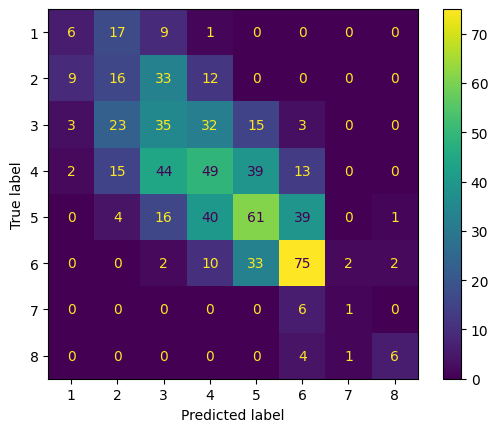

In [107]:
# use fitted model to predict
y_pred = pipeline.predict(X_test)
results = display_results(y_test, y_pred)
pprint.PrettyPrinter(width = 20).pprint(results)
plt.show()

## LightGBM on the no-professional player dataset

This test is to see whether the addition of `Age`, `HoursPerWeek`, and `TotalHours` affects performance to a noticeable degree. 

In [99]:
X_train, X_test, y_train, y_test = make_train_test_set(data_rows_removed,
                                                      test_size = 0.2)

l2_penalty = np.logspace(-3,3,10)
l1_penalty = np.logspace(-3,2,10)
lrs = np.logspace(-2,0,5)
n_estimators = [100, 200, 400]
model = lgb.LGBMClassifier()
distributions = {
    "model__learning_rate": lrs,
    "model__reg_alpha": l1_penalty,
    "model__reg_lambda" : l2_penalty,
    "model__n_estimators": n_estimators
}
smote_val = 50
pipeline = create_pipeline(model, 
                           smote_val = smote_val)
cv = RepeatedStratifiedKFold(n_splits =5, n_repeats = 3, 
                                 random_state = 99)

# random search for hyperparameters
clf = RandomizedSearchCV(pipeline, distributions, 
                         n_iter = 50,
                         cv = cv,
                         scoring = 'f1_weighted', random_state=100,
                        error_score = 'raise')
search = clf.fit(X_train, y_train )

model = lgb.LGBMClassifier(learning_rate = search.best_params_['model__learning_rate'], 
                           reg_lambda = search.best_params_['model__reg_lambda'],
                          reg_alpha = search.best_params_['model__reg_alpha'],
                          n_estimators = search.best_params_['model__n_estimators'])
pipeline = create_pipeline(model, smote_val = smote_val)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversample',
                 BorderlineSMOTE(sampling_strategy=<function create_pipeline.<locals>.SMOTE_Distribution at 0x00000253666298B0>)),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(learning_rate=0.03162277660168379,
                                n_estimators=200,
                                reg_alpha=0.046415888336127795,
                                reg_lambda=0.46415888336127775))])

In [100]:
sklearn.metrics.accuracy_score(y_test, [4 for _ in range(len(y_test))])

0.24357034795763993

{'acc': 0.3767019667170953,
 'balanced acc': 0.32383045076098843,
 'unaggregated f1': {1: 0.2978723404255319,
                     2: 0.366412213740458,
                     3: 0.2949308755760369,
                     4: 0.4066852367688022,
                     5: 0.3300330033003301,
                     6: 0.4901185770750988,
                     7: 0.16666666666666666},
 'weighted f1': 0.3729254299853203}


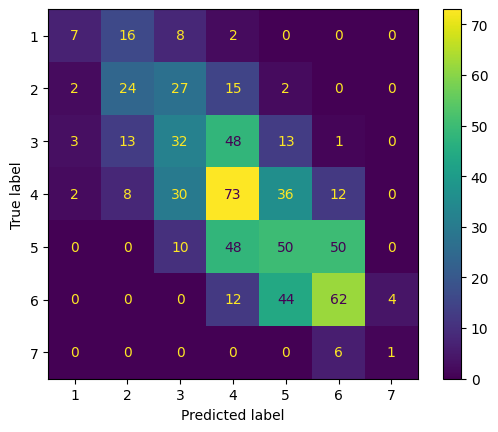

In [101]:
y_pred = pipeline.predict(X_test)
results = display_results(y_test, y_pred)
pprint.PrettyPrinter(width = 20).pprint(results)
plt.show()

# Summary

While we are able to see trends from the data analysis, our model only does a bit better than just predicting the majority class (36.6% accuracy vs. 23.8%), so I would recommend iterating on the data collection and modeling before deploying this. If we break down which ranks our model is relatively good at predicting, it would be Master and Professional players, as evidenced by the larger dis-aggregated f1-scores.

There are a couple areas where our model does poorly. First, the model seems poor at predicting tail classes like bronze and grandmaster ranks. This particular behavior is driven by the data imbalance as noted earlier. 

Moreover, the model is not able to distinguish among close ranks, with a lot of false predictions existing on the sub and super-diagonal of the confusion matrix. My theory for this is because there is not a lot of differences between neighboring ranks. For example, a Master and a Grandmaster player probably has a lot of similar behavior from a micro-perspective. If we're not specifically targeting a rank, it might be useful to group ranks together ex. low/medium/high/pro skill buckets.

An interesting thing to note is that Grandmaster players are never classified as professional players by the model, which partly justifies keeping pro as a separate skill bucket above. This could potentially be because of the small sample size of Grandmaster players, or it could also be because Grandmaster and Master players are far more similar than Grandmaster and professional players.

### Data Discussion
A model that predicts a player's rank is still possible, but it would require a bit more data and feature collection. Ideally, we would collect data across the board, but we should specifically focus on the tails and get more observations of Grandmaster, Professional and Bronze players (up-sampling/down-sampling can only do so much to improve performance). 

It should also be noted that each observation is only a single game from the player, which potentially makes the features we observe inaccurate. To improve on this, we should collect the recent play history of the player and average the performance features across that history to get a more consistent estimate of their performance.

Moreover, we should be more considerate of what kind of data to collect. Some of the features such as `unique units` made might not be that useful of a predictor ex. a Terran player could probably play marine/tank comps into zerg pretty easily throughout ranks, which makes the unique units feature somewhat non-informative. Or the `workers made` feature, which would be much different for Zerg players vs. terran players.

On that note, it is strange that we do not have data about what race the player is using, as that could easily affect APM (ex. mutalisk micro vs. marine stutter-stepping) and other features. It is probably worthwhile to collect that data, since it should be easily retrieved from the gameID.

It is also surprising that almost all the features are micro-focused, especially since Starcraft also has an emphasis on macro gameplay. Data on resource efficiency and management (ex. time supply blocked, production idle time etc.) could be useful additional features.